# 1. Objet

Ce notebook a pour objet de traiter les fichiers bruts mis en entrée dans le répertoire `data`. Il s'agit des fichiers : 
- d'historiques de vente
- de référentiel client

Etant donné la simplicité des traitements faits sur le référentiel client, ils sont fait directement dans ce fichier.

# 2. Setup et imports

In [2]:
from pathlib import Path
import sys
import datetime
import pandas as pd
idx = pd.IndexSlice
project_root = str(Path(sys.path[0]).parents[0].absolute())
project_root
if project_root not in sys.path:
    sys.path.append(project_root)
data_path = Path('..') / 'data'
persist_path = Path('..') / 'persist'

import multiprocessing as mp

from IPython.display import display, HTML
display(HTML("<style>.container { width:90%; }</style>"))

Définition du client Dask

In [3]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
# Paramètres pour les traitements "tout-venant"
std_client_kwargs = dict(
    n_workers=int(0.9 * mp.cpu_count()),
    processes=True,
    threads_per_worker=1,
    dashboard_address=':36000',
)

# Paramètres pour la constitution de l'index, gourmand en mémoire.
heavy_client_kwargs = dict(
    n_workers=1,
    threads_per_worker=8,
    processes=True,
    memory_limit='31GB',
    dashboard_address=':36000',
)

2. Définition de la liste des succursales

In [4]:
orgacom_list = [
    '1ALO',
    '1BFC',
    '1CAP',
    '1CTR',
    '1EXP',
    '1LRO',
    '1LXF',
    '1NCH',
    '1OUE',
    '1PAC',
    '1PNO',
    '1PSU',
    '1RAA',
    '1SOU',
    '2BRE',
    '2CAE',
    '2CTR',
    '2EST',
    '2IDF',
    '2IFC',
    '2MPY',
    '2NOR',
    '2RAA',
    '2SES',
    '2SOU',
]

# 3. Vérification du périmètre déjà traité

Ce paragraphe sert à déterminer quelles sont les dates qui ont été déjà intégrées, à la fois dans le fichier d'historique et le fichier détrompeur.


L'avancement du traitement (qques dizaines de secondes) peut être suivi via le dashboard à l'adresse http://devdm:36000 (le dashboard ne s'affiche que lorsque le traitement est lancé).

In [4]:
ddf = dd.read_parquet(persist_path / 'raw_data.parquet')
with LocalCluster(**std_client_kwargs) as cluster, Client(cluster) as client_:
    max_histo_date = ddf.index.max().compute()
    
print(f"Le fichier d'historique contient des données jusqu'au {max_histo_date} inclus.")

Le fichier d'historique contient des données jusqu'au 2021-05-31 00:00:00 inclus.


Le chargement du fichier détrompeur ne prend que peu de temps.

In [5]:
max_detromp_month = pd.read_csv(
    data_path / 'detrompeur_data.csv',
    encoding='latin1',
    sep=';',
    names=['orgacom', 'month', 'year', 'currency', 'weight_unit', 'weight_unit2', 'weight', 'weight2', 'brutrevenue', 'netrevenue', 'net2revenue', 'margin'],
    skiprows=[0],
    dtype={
        'orgacom': pd.CategoricalDtype(orgacom_list),
        'month': 'object',
        'year': 'object',
        'weight': 'float',
    },
    decimal=',',
    thousands=' ',
)['month'].max()

print(f"Le fichier détrompeur contient des données jusqu'au mois '{max_detromp_month}'.")

Le fichier détrompeur contient des données jusqu'au mois '202105'.


# 4. Données pour contrôle

On récupère des données agrégées issues directement de la LISTCUBE dans PBI, afin de contrôler à la volée que l'extraction et le chargement des données à une maille fine se sont bien passés.

Le mode opératoire pour ce rafraîchissement de données s'affiche en cliquant sur le lien ci-dessous. 

<details><summary><span style="color:blue"><b>Mode opératoire pour rafraîchir l'extraction</b></span></summary>

1. se connecter à PBI
2. lancer la transaction LISTCUBE, renseigner le cube **ZVT_C151**, laisser les cases décochées et exécuter
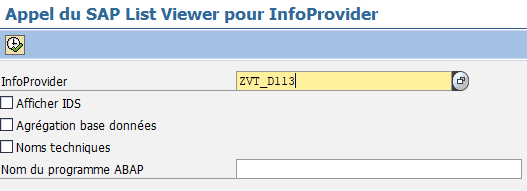
3. valider la popup qui s'affiche
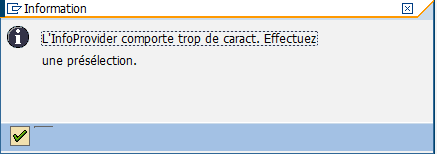
4. selectionner les champs suivants dans la fenêtre qui s'affiche :
    - 0SALESORG : Org. commerciale
    - 0CALYEAR : Année civile
    - 0CALMONTH : Année civile/mois
    - ZCABRUT : CA brut
    - ZCANET : CA net
    - ZCANET2 : CA net net
    - ZVT_MAPRN : Marge de gestion PRN
    - 0G_QVVPDN : Poids net
    - 0NET_WGT_DL : Poids net
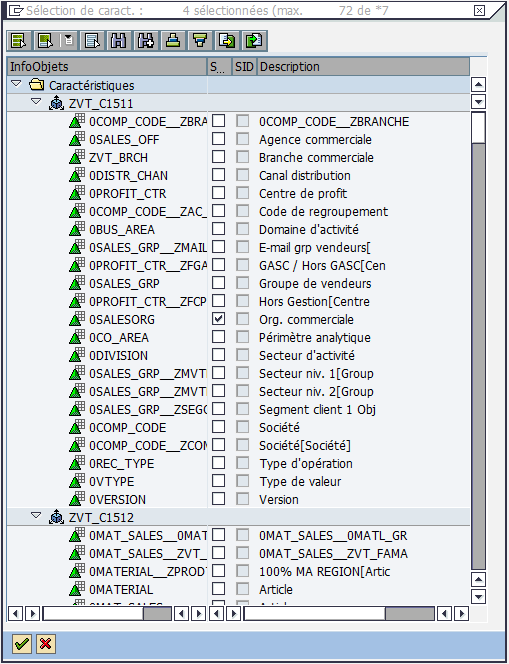
4. dans l'écran suivant, saisir les critères suivants : 
    - Organisation commerciale : 1* et 2*
    - Année civile/mois : la plage de date souhaitée. Bien mettre TOUT le périmètre de date (en partant de, cette extraction fonctionne en annule et remplace.
    - Aggrégation BD : cochée
    - Nb occurences maxi : vide
    
puis cliquer sur **Sélect. zne pr édition**.
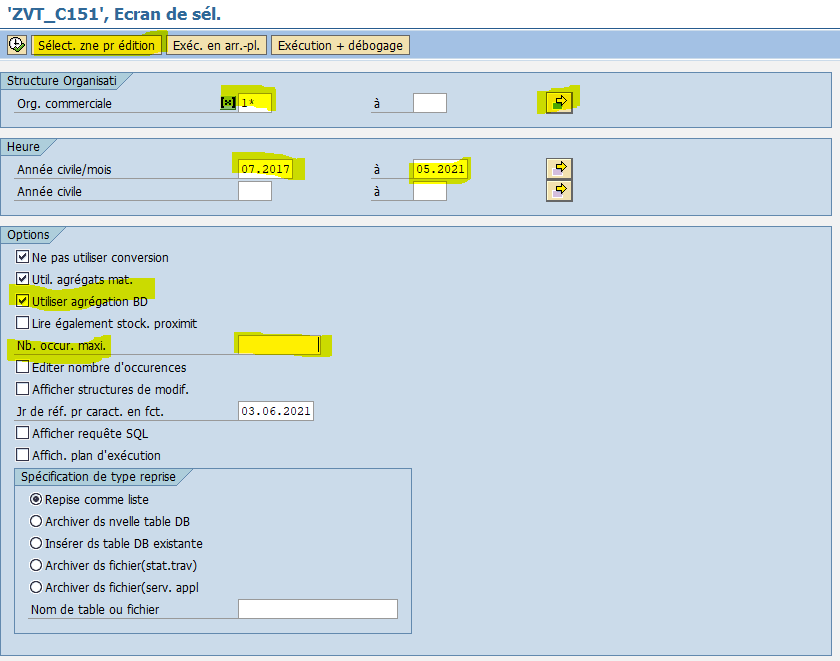
5. dans l'écran suivant, marquer tous les champs puis exécuter
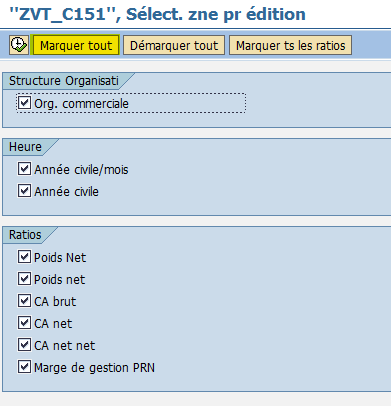
6. de retour à l'écran de sélection, exécuter la transaction. Le résultat s'affiche.
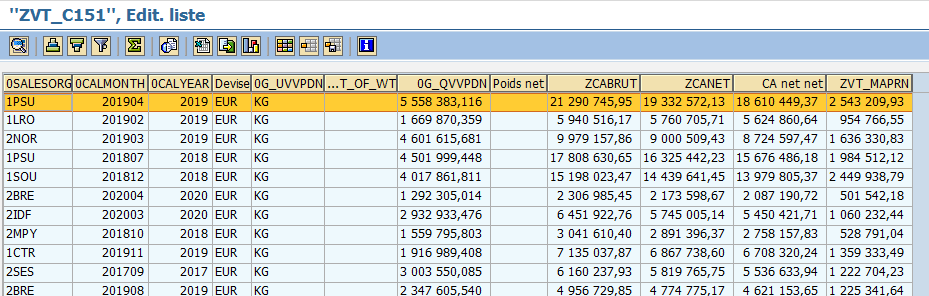
7. enregistrer le résultat au format excel
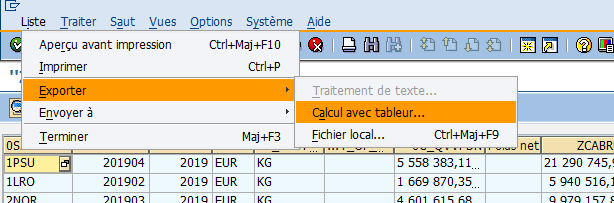
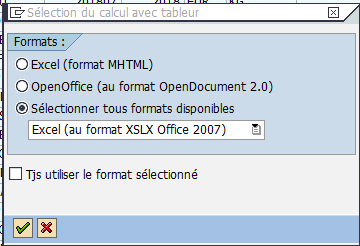
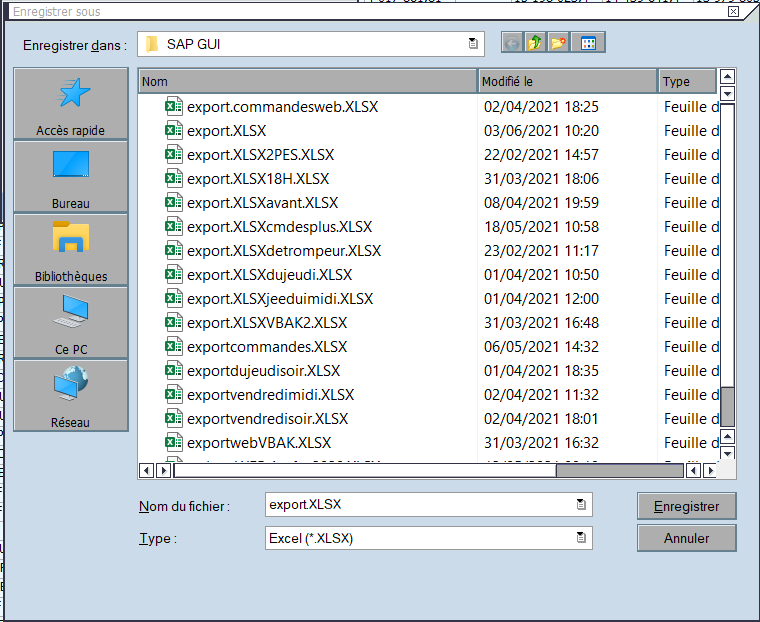
8. Sauvegarder le fichier au format csv en le renommant **detrompeur_data.csv**
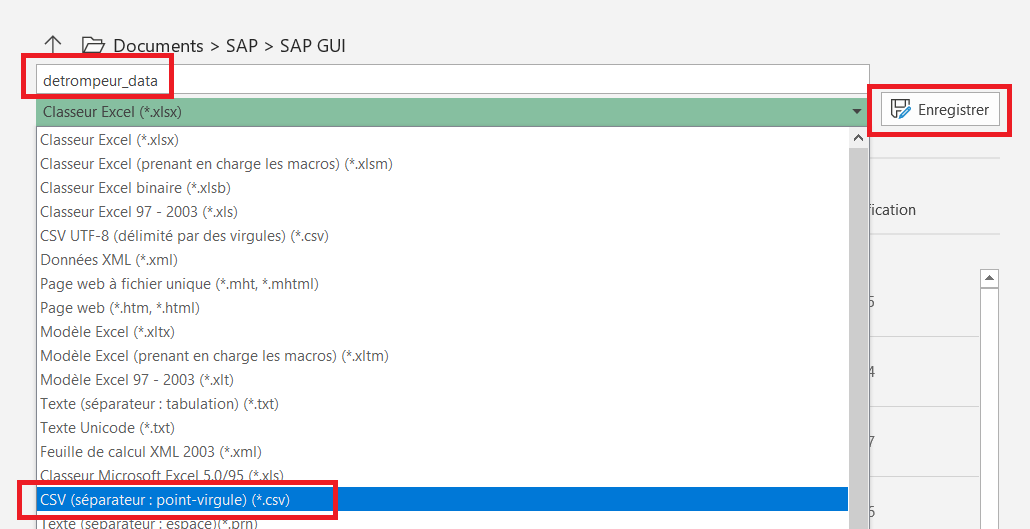
9. Via **MobaXTerm**, uploader le fichier dans le répertoire **/homedm/pmasse/WebOrNot/data/** en écrasant la version précédente.
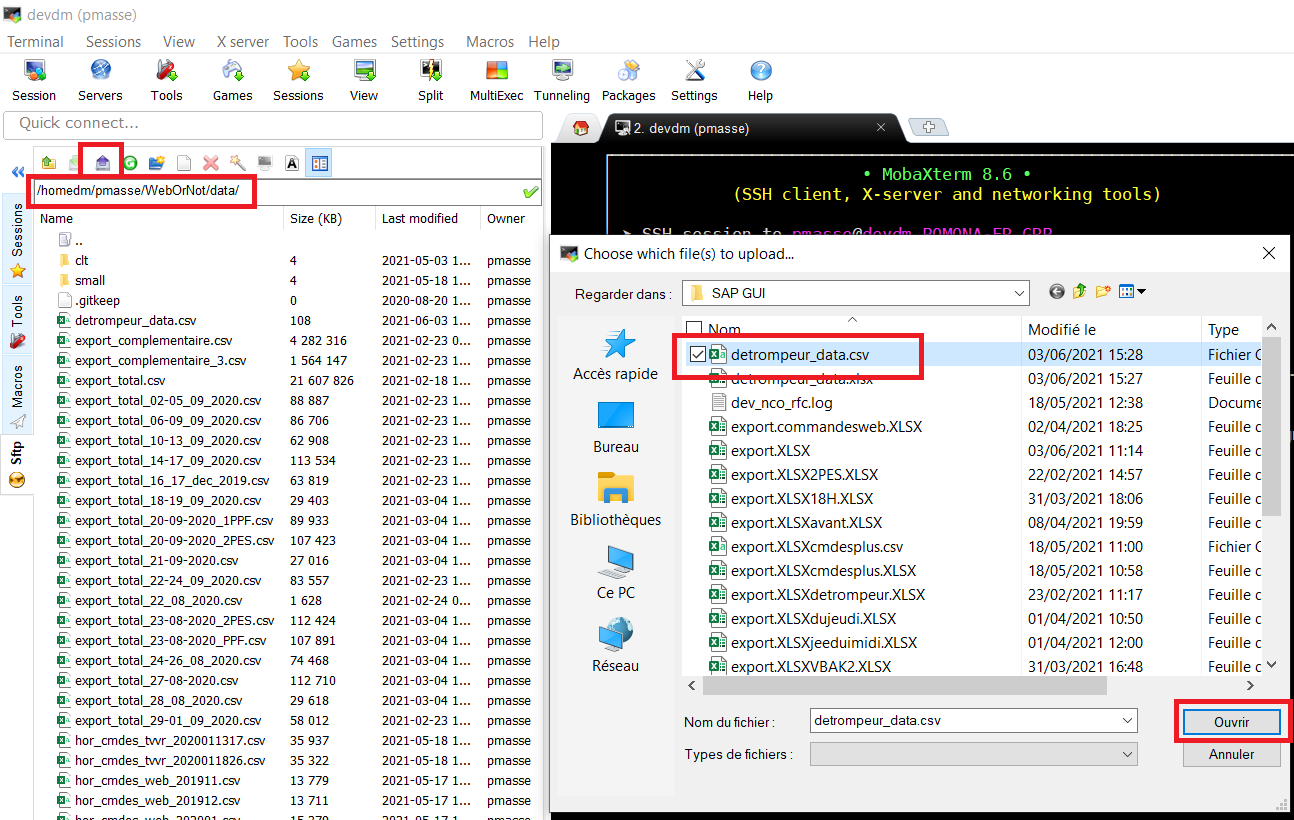
</details>

1. Définition des champs qui serviront à faire le contrôle

Ce sont ces champs qui sont comparés entre le détrompeur et les fichiers d'historiques.

In [7]:
fields_to_compare = ['weight', 'brutrevenue', 'margin']

2. Définition des mois à contrôler

**Remarque :** cette liste doit être mise à jour si le périmètre est étendu.

In [8]:
months = [
    '201707',
    '201708',
    '201709',
    '201710',
    '201711',
    '201712',
    '201801',
    '201802',
    '201803',
    '201804',
    '201805',
    '201806',
    '201807',
    '201808',
    '201809',
    '201810',
    '201811',
    '201812',
    '201901',
    '201902',
    '201903',
    '201904',
    '201905',
    '201906',
    '201907',
    '201908',
    '201909',
    '201910',
    '201911',
    '201912',
    '202001',
    '202002',
    '202003',
    '202004',
    '202005',
    '202006',
    '202007',
    '202008',
    '202009',
    '202010',
    '202011',
    '202012',
    '202101',
    '202102',
    '202103',
    '202104',
    '202105',
    '202106',
]

3. Chargement des données

In [11]:
ctrle = pd.read_csv(
    data_path / 'detrompeur_data.csv',
    encoding='latin1',
    sep=';',
    names=['orgacom', 'month', 'year', 'currency', 'weight_unit', 'weight_unit2', 'weight', 'weight2', 'brutrevenue', 'netrevenue', 'net2revenue', 'margin'],
    skiprows=[0],
    dtype={
        'orgacom': pd.CategoricalDtype(orgacom_list),
        'month': pd.CategoricalDtype(months),
        'year': 'object',
        'weight': 'float',
    },
    decimal=',',
    thousands=' ',
).loc[lambda x: x.month.isin(months)].set_index(['orgacom', 'month']).sort_index()
ctrle

year currency weight_unit  weight_unit2       weight  weight2  \
orgacom month                                                                   
1ALO    201707  2017      EUR          KG           NaN  3144714.984      0.0   
        201708  2017      EUR          KG           NaN  3329429.530      0.0   
        201709  2017      EUR          KG           NaN  4543058.400      0.0   
        201710  2017      EUR          KG           NaN  4406942.653      0.0   
        201711  2017      EUR          KG           NaN  4670216.793      0.0   
...              ...      ...         ...           ...          ...      ...   
2SOU    202102  2021      EUR          KG           NaN  1416472.891      0.0   
        202103  2021      EUR          KG           NaN  1896552.670      0.0   
        202104  2021      EUR          KG           NaN  1382067.796      0.0   
        202105  2021      EUR          KG           NaN  1718360.298      0.0   
        202106  2021      EUR          KG           NaN  2304405.851      0.0   

                brutrevenue   netrevenue  net2revenue      margin  
orgacom month                                                      
1ALO    201707  10426960.20  10024879.18   9742979.65  1666902.18  
        201708  10984996.41  10579208.70  10294519.29  1817023.14  
        201709  14679332.61  14122353.46  13743135.09  2374842.11  
        201710  14542930.00  13948005.52  13567019.14  2298395.93  
        201711  15618497.28  15023089.41  14630158.70  2468127.12  
...                     ...          ...          ...         ...  
2SOU    202102   2447287.77   2323757.05   2233274.05   464595.58  
        202103   3405178.57   3229704.74   3108619.50   616387.31  
        202104   2412783.90   2295076.80   2209327.29   444432.27  
        202105   3277515.81   3121744.18   3017696.51   658273.29  
        202106   4465492.24   4290981.39   4167745.15   931905.42  

[1167 rows x 10 columns]

# 5. Historiques de vente

On récupère ensuite les données d'historique de vente depuis **PBI**. Pour que le contrôle mois par mois via le détrompeur, tourne correctement le rafraîchissement doit se faire sur un mois complet.

<details><summary><span style="color:blue"><b>Mode opératoire pour rafraîchir l'extraction</b></span></summary>

1. Vérifier le profil utilisateur qui lance le Open Hub pour la représentation décimale
 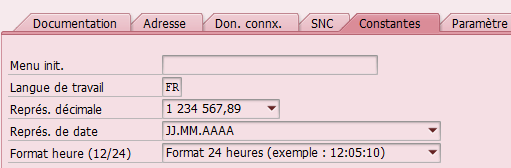

2. Exécuter le *Open Hub Dest.* 'Données COPA' (ZOH_COPA) avec les bons filtres

3. Modifier les filtres pour prendre en compte les bonnes dates (selectionner sur ‘Année civile/mois’) et sur la liste des organisations commerciales ci-après :
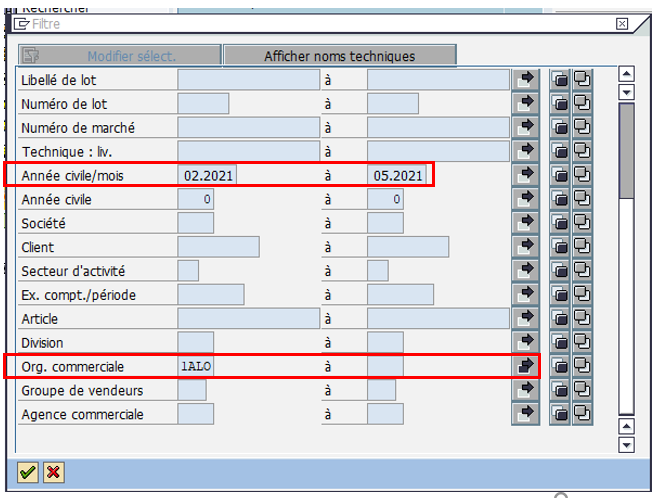
    1ALO
    1BFC
    1CAP
    1CTR
    1EXP
    1LRO
    1LXF
    1NCH
    1OUE
    1PAC
    1PNO
    1PSU
    1RAA
    1SOU
    2BRE
    2CAE
    2CTR
    2EST
    2IDF
    2IFC
    2MPY
    2NOR
    2RAA
    2SES
    2SOU
    
    
100. Lorsque le fichier a été généré dans le répertoire d'export de BW, lancer MobaXTerm, et dans la console taper les commandes suivantes : 
    - **cd /pomona/ExportBW/** : cette commande permet de se positionner dans le répertoire d'export de BW
    - **ls -altrh** : cette commande affiche les fichiers du répertoire, avec les derniers fichiers modifiés en bas. Contrôler que le fichier exporté est bien présent, noter sa taille.
    - **df -h** : cette commande affiche l'espace disque disponible sur la machine. Contrôler que le disque **homedm** a assez d'espace disque disponible.
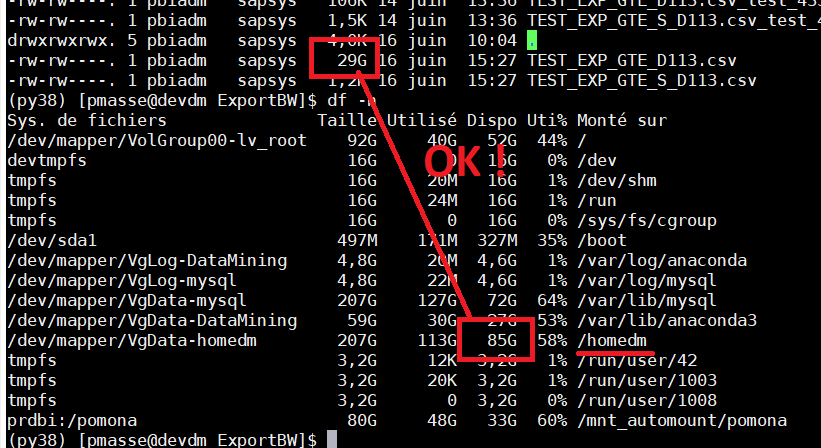
    
    - **sudo chmod 666 nom_du_fichier** : cela donne le droit à tout le monde de lire ou déplacer le fichier. Le mot de passe pour sudo est **pmasse**
    - **mv nom_du_fichier nouveau_nom_du_fichier**: cela renomme le fichier
    - **mv nom_du_fichier /homedm/pmasse/WebOrNot/data/** : cela déplace le fichier vers le répertoire d'entrée du projet
    
</details>

1. Définition du format du csv

Cette définition ne doit normalement pas changer au fil des rafraîchissements.

In [40]:
init_fields = {'orgacom': pd.CategoricalDtype(orgacom_list),
          'month': pd.CategoricalDtype(months),
          'week': 'category',
          'date': 'object',
          'pricetype_init': 'object',
          'pricetype_applied': 'object',
          'mercu_init': 'object', 
          'mercu_applied': 'object',
          'client': 'object',
          'doctype': 'object',
          'origin': pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB', '#', 'SCHR', 'TELE',
                                         'MUEN', 'FRN', 'DFUE'], ordered=True),
          'salesgroup': 'object',
          'material': 'object',
          'brutrevenue': 'float',
          'brutrevcur': 'object', 
          'netrevenue': 'float', 
          'netrevcur': 'object',
          'weight': 'float',
          'weightunit': 'object',
          'margin': 'float', 
          'margincur': 'object', 
          'marginperkg': 'float',
         }

2. Paramètres pour l'interprétation du csv

Normalement, ces paramètres ne doivent pas être modifiés.

In [41]:
# def converter(str_in):
#     if str(str_in)[-1] == '-':
#         return(- float(str_in.strip()[:-1]))
#     else:
#         return(float(str_in.strip()))

In [42]:
read_csv_kwargs = dict(
    sep=";",
    header=None,
    names=list(init_fields.keys()),      
    dtype=init_fields, 
    parse_dates=['date'],
    decimal=',',
#    thousands=',',
#     converters={
#         'margin': converter,
#         'marginperkg': converter,
#         'weight': converter,
#         'brutrevenue': converter,
#         'netrevenue': converter,
#     }
)

3. Définition des fichiers bruts

Ces fichiers doivent être dans le répertoire `data`.

La liste des fichiers **doit** être mise à jour pour que les nouveaux fichiers extraits soient correctement pris en compte.

Il est important de ne pas avoir de recouvrement entre les dates d'extraction, sinon les indicateurs seront doublés pour les périodes de recouvrement !


In [43]:
raw_data_filenames = [
#     'export_total.csv',  # premier export, qui a foiré sur l'année 2020 en gros
#     'export_complementaire.csv',  # première moitié de 2020 - interrompu ensuite
#     'export_complementaire_3.csv',  # export de la seconde moitié de 2020
#     'export_total_16_17_dec_2019.csv',  # 16 et 17 décembre 2019, qui manquaient
#     'export_total_29-01_09_2020.csv',
#     'export_total_22-24_09_2020.csv',
#     'export_total_14-17_09_2020.csv',
#     'export_total_10-13_09_2020.csv',
#     'export_total_06-09_09_2020.csv',
#     'export_total_02-05_09_2020.csv',
#     'export_total_23-08-2020_2PES.csv',
#     'export_total_23-08-2020_PPF.csv',
#     'export_total_24-26_08_2020.csv',
#     'export_total_27-08-2020.csv',
#     'export_total_28_08_2020.csv',
#     'export_total_18-19_09_2020.csv',
#     'export_total_20-09-2020_1PPF.csv',
#     'export_total_20-09-2020_2PES.csv',
#     'export_total_21-09-2020.csv',
    'TEST_EXP_GTE_D113.csv',
    'HISTO_VT_JUIN2021.csv',

#     
    
#     
#     'EXTRACT_LIGNES_VENTES_V3.csv',  # NE PAS PRENDRE ! Juste pour vérifier que mon outil de contrôle identifiait bien les écarts liés à l'absence de soum (spoiler alert: c'est bon!)
]
raw_data_paths = [data_path / filename for filename in raw_data_filenames]

4. Lecture des csv, application de l'index et enregistrement sur le disque

**Attention, cette étape prend plusieurs heures !!!** 

Le suivi peut se faire à l'url http://devdm:36000 une fois le traitement lancé. La création du client prend quelques minutes. Le dashboard n'est accessible qu'à ce moment-là.

Par sécurité, la ligne pour lancer le traitement a été commentée, bien penser à la décommenter (et recommenter une fois le traitement terminé).

In [ ]:
%%time
ddf = dd.read_csv(
    raw_data_paths,
    **read_csv_kwargs,
).set_index('date')

###########################################
# Lignes ci-dessous à décommenter avant de lancer la cellule pour lancer le traitement.
###########################################

with LocalCluster(**heavy_client_kwargs) as cluster, Client(cluster) as client_:
    print(client_.dashboard_link)
    ddf.to_parquet(
        persist_path / 'raw_data.parquet',
        overwrite=True,
        engine='fastparquet',
    )

###########################################

http://127.0.0.1:36000/status


5. Contrôle de la conformité des données

In [5]:
ddf = dd.read_parquet(persist_path / 'raw_data.parquet')

A nouveau, l'avancement peut être consulté via le dashboard à l'url http://devdm:36000 (une fois le traitement lancé, quelques dizaines de secondes).

In [9]:
with LocalCluster(**std_client_kwargs) as cluster, Client(cluster) as client_:
    grouped = ddf.loc[:, ['orgacom', 'month', *fields_to_compare]].groupby(['orgacom', 'month']).sum().compute()
grouped

weight  brutrevenue      margin
orgacom month                                       
1ALO    201707  3144714.984  10426960.20  1666902.18
        201708  3329429.530  10984996.41  1817023.14
        201709  4543058.400  14679332.61  2374842.11
        201710  4406942.653  14542930.00  2298395.93
        201711  4670216.793  15618497.28  2468127.12
...                     ...          ...         ...
2SOU    202102  1416472.891   2447287.77   464595.58
        202103  1896552.670   3405178.57   616387.31
        202104  1382067.796   2412783.90   444432.27
        202105  1718360.298   3277515.81   658273.29
        202106  2304405.851   4465492.24   931905.42

[1200 rows x 3 columns]

A cette étape, la comparaison est faite entre le détrompeur et les données d'historique. Historiquement, il y a un écart sensible sur la marge pour 2NOR pour le mois de décembre 2018 (12-13%).

In [15]:
delta = (
    grouped
    .merge(
        ctrle.loc[:, fields_to_compare],
        suffixes=(None, '_ctrle'),
        left_index=True,
        right_index=True,
        indicator=False,
        how='outer'
    )
    .fillna(0)
    .assign(
        **{indicator + '_delta': lambda x, i=indicator: (x[i] - x[i + '_ctrle']) / (x[i + '_ctrle'])
           for indicator in fields_to_compare
          }
    )
    .drop([*[indicator for indicator in fields_to_compare], *[indicator + '_ctrle' for indicator in fields_to_compare]], axis=1)
    .unstack('orgacom')
    .swaplevel(axis=1)
    .sort_index(axis=1)
)

print(f"Le plus gros écart au niveau indicateur x succursale x mois est de {delta.abs().max().max():.8%}.")

with pd.option_context('display.max_columns', None, 'display.float_format', lambda x: f'{x:.2%}'):
    display(delta.style.format('{:,.2%}'.format).bar(align='mid', axis=None))
    


Le plus gros écart au niveau indicateur x succursale x mois est de 0.00000002%.


In [16]:
delta.to_pickle(persist_path / 'current_delta.pkl')

6. Itération - ANCIENNE VERSION, PLUS NECESSAIRE.

In [ ]:
# delta_list = []

# for cpt0, orgacom in enumerate(orgacom_list):
#     print(f'---------------------------------------------------')
#     print(f'--------       Succursale {orgacom} - {cpt0 + 1}/{len(orgacom_list)}       --------')
#     print(f'---------------------------------------------------\n')
#     df_list = []
#     for cpt, raw_data_filename in enumerate(raw_data_filenames):
#         print(f'Traitement du fichier {cpt + 1}/{len(raw_data_filenames)} - {raw_data_filename}')
#         print(f'          --------------------           ')
#         iterator = pd.read_csv(data_path / raw_data_filename, **iterator_kwargs)
#         print(f"{datetime.datetime.now()} - Début de l'itération")
#         for cpt2, content in enumerate(iterator):
#             print(f'{datetime.datetime.now()} - Run {cpt2 + 1}')
#             df_list.append(content.loc[lambda x: x.orgacom == orgacom])
#     print(f'{datetime.datetime.now()} - Fin du traitement des fichiers pour la succursale {orgacom} !')
#     print(f'          --------------------           ')    
#     print(f'{datetime.datetime.now()} - Concaténation pour la succursale {orgacom}')
#     oc_df = pd.concat(df_list, axis=0)
#     oc_df = oc_df.reset_index(drop=True)

#     print(f'{datetime.datetime.now()} - Enregistrement sur disque pour la succursale {orgacom}\n')
#     filename = f'data_{orgacom}.pkl'    
#     oc_df.to_pickle(persist_path / 'rawbyoc' / filename)
    
#     print(f'{datetime.datetime.now()} - Contrôle de la conformité des données pour la succursale {orgacom}')
#     reference = ctrle.loc[idx[orgacom, months], fields_to_compare]
#     to_check = oc_df.groupby(['orgacom', 'month'], observed=True)[fields_to_compare].sum()
#     aligned = reference.align(to_check, fill_value=0.)
#     delta_list.append((aligned[0] - aligned[1]) / aligned[0])

#     del(oc_df)

# print('Traitement terminé !')
    
# delta = pd.concat(delta_list).unstack('orgacom').swaplevel(axis=1).sort_index(axis=1)
# del(delta_list)
# with pd.option_context('display.float_format', lambda x: f'{x:.2%}', 'display.max_columns', None):
#     display(delta)
# delta.to_pickle(persist_path / 'current_delta.pkl')


# 4. Référentiel client

1. Définition des entêtes des fichiers à intégrer

In [7]:
field_names = [
    'client',
    'V',
    'groupecompte',
    'nom',
    'postalcode',
    'seg1',
    'seg2',
    'seg3',
    'seg4',
    'cat',
    'sscat',
    'saiso',
    'surcat',
    'ecom',
    'sectact',
    'canal',
    'orgacom',
    'grpclt1',
    'grpclt2',
    'grpclt3',
    'grpclt4',
    'grpclt5',
    'agence',
    'condexp',
    'pricetype',
    'relationtype',
    'pilcom',
    'hier4',
    'hier3',
    'hier2',
    'hier1',
    'adrnr',
    'city',
    'SIRET',
    'hier4_l',
    'SIREN',
    'street',
    'V2',
    'hier3_l',
    'hier2_l',
    'hier1_l',
    'mandant_deletion_indicator',
    'sales_org_deletion_indicator',    
]

2. Définition des formats initiaux (i.e. l'interprétation "brute" du fichier)

In [8]:
initial_dtypes = {
    'client': 'object',
    'V': 'object',
    'groupecompte': 'object',
    'nom': 'object',
    'postalcode': 'object',
    'seg1': 'object',
    'seg2': 'object',
    'seg3': 'object',
    'seg4': 'object',
    'cat': 'object',
    'sscat': 'object',
    #'saiso': 'bool', # défini dans le converter du read_csv
    'surcat': 'object',
    #'ecom': 'bool', # défini dans le converter du read_csv
    'sectact': 'object',
    'canal': 'object', 
    'orgacom': 'object', 
    'grpclt1': 'object',
    'grpclt2': 'object',
    'grpclt3': 'object',
    'grpclt4': 'object',
    'grpclt5': 'object',
    'agence': 'object', 
    'condexp': 'object', 
    'pricetype': 'object', 
    'relationtype': 'object',
    'pilcom': 'object',
    'hier4': 'object',
    'hier3': 'object',
    'hier2': 'object',
    'hier1': 'object',
    'adrnr': 'object',
    'city': 'object',
    'SIRET': 'object',
    'hier4_l': 'object',
    'SIREN': 'object',
    'street': 'object',
    'V2': 'object',
    'hier3_l': 'object',
    'hier2_l': 'object',
    'hier1_l': 'object',
#     'mandant_deletion_indicator': 'bool',  # défini dans le converter du read_csv
#     'sales_org_deletion_indicator': 'bool',  # défini dans le converter du read_csv 
}

3. Définition des formats "cibles" du DataFrame. On fait en 2 temps pour la gestion des données `Categorical` (on concatène d'abord les dataframes pour que la converions en `Categorical` "voie" l'ensemble des valeurs).

In [9]:
target_dtypes = {
    'client': 'object',
    'V': 'category',
    'groupecompte': 'category',
    'nom': 'object',
    'postalcode': 'category',
    'seg1': 'category',
    'seg2': 'category',
    'seg3': 'category',
    'seg4': 'category',
    'cat': 'category',
    'sscat': 'category',
    #              'saiso': 'bool',
    'surcat': 'category',
    #              'ecom': 'bool', 
    'sectact': 'category',
    'canal': 'category', 
    'orgacom': 'category', 
    'grpclt1': 'category',
    'grpclt2': 'category',
    'grpclt3': 'category',
    'grpclt4': 'category',
    'grpclt5': 'category',
    'agence': 'category', 
    'condexp': 'category', 
    'pricetype': 'category', 
    'relationtype': 'category',
    'pilcom': 'category',
    'hier4': 'object',
    'hier3': 'object',
    'hier2': 'object',
    'hier1': 'object',
    'adrnr': 'object',
    'city': 'object',
    'SIRET': 'object',
    'hier4_l': 'object',
    'SIREN': 'object',
    'street': 'object',
    'V2': 'object',
    'hier3_l': 'object',
    'hier2_l': 'object',
    'hier1_l': 'object',
#     'mandant_deletion_indicator': 'bool',  # défini dans le converter du read_csv
#     'sales_org_deletion_indicator': 'bool',  # défini dans le converter du read_csv     
            }

4. Définition des arguments du read_csv

In [10]:
csv_kwargs = dict(
    sep=';',
    encoding='latin1',
    skiprows=[0], # skip header row
    names=field_names,
    dtype=initial_dtypes,
    converters={
        'saiso': lambda x: True if x == 'YES' else False, 
        'ecom': lambda x: True if x == 'X' else False,
        'mandant_deletion_indicator': lambda x: True if x == 'X' else False,
        'sales_org_deletion_indicator': lambda x: True if x == 'X' else False,
    },
)

5. Lecture, concaténation des dataframes, et définition des catégories

In [11]:
%%time

filenames = [
    'ref_clt_1PPF.csv',
    'ref_clt_2PES.csv',
]
df_list = [
    pd.read_csv(
        data_path / 'clt' / filename,
        **csv_kwargs,
    ) for filename in filenames
]
df_clt = pd.concat(df_list, axis=0)
del(df_list)
df_clt = df_clt.astype(target_dtypes)

CPU times: user 4.15 s, sys: 529 ms, total: 4.68 s
Wall time: 4.68 s


6. Nettoyages divers

In [12]:
# remove emppty client codes
df_clt = df_clt.loc[~df_clt.client.isna()]

# zero pad numeric clients codes
num_clt_mask = df_clt['client'].str.isnumeric()
df_clt.loc[num_clt_mask, 'client'] = df_clt.loc[num_clt_mask, 'client'].str.zfill(10)

#remove duplicated clients
print(f'Clients count before cleansing : {df_clt.client.count()}')
print(f"Duplicated clients before cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")
df_clt = df_clt.loc[~(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False) & df_clt.sectact.isna())]
print(f"Clients count after cleansing : {df_clt.client.count()}")
print(f"Duplicated clients after cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")

# set the index
df_clt.set_index(['orgacom', 'client'], inplace=True, drop=True)

Clients count before cleansing : 595218
Duplicated clients before cleansing: 26887
Clients count after cleansing : 581770
Duplicated clients after cleansing: 0


In [13]:
df_clt.sort_index()

V groupecompte                                  nom  \
orgacom client                                                            
1ALO    0000010005  A         ZCLT                AKTO RESEAU INTERGROS   
        0000010007  A         ZCLT           LOGISTIQUE VIANDE DE L'EST   
        0000010087  A         ZCLT         ERHARD VIENNOISERIE TRAITEUR   
        0000010140  A         ZHIE                           CASINO R2C   
        0000010141  A         ZHIE               CASINO REST PLATEFORME   
...                ..          ...                                  ...   
2SOU    ZZ001616    A         0100            ES CESTAS - Agence Tarbes   
        ZZ001617    A         0100  ES CESTAS - Agence  Benesse Maremne   
        ZZ003312    A         0100       PF Bordeaux - Entrepot Tresses   
        ZZ006M14    A         0100            ES CESTAS - Agence Tarbes   
        ZZ00STEF    A         0100              ES CESTAS - Agence  TFE   

                   postalcode seg1 seg2 seg3 seg4  cat sscat  ...  \
orgacom client                                                ...   
1ALO    0000010005      93192   Z4   Z0   ZQ   ZO   Z5   Z27  ...   
        0000010007      54710   Z4   Z9   ZO   ZM   Z3   Z26  ...   
        0000010087      25870   Z1   Z3   ZH   ZX   ZK   Z07  ...   
        0000010140      42000  NaN  NaN  NaN  NaN  NaN   NaN  ...   
        0000010141      42000  NaN  NaN  NaN  NaN  NaN   NaN  ...   
...                       ...  ...  ...  ...  ...  ...   ...  ...   
2SOU    ZZ001616        65000  NaN  NaN  NaN  NaN  NaN   NaN  ...   
        ZZ001617        40230  NaN  NaN  NaN  NaN  NaN   NaN  ...   
        ZZ003312        33370  NaN  NaN  NaN  NaN  NaN   NaN  ...   
        ZZ006M14        65000  NaN  NaN  NaN  NaN  NaN   NaN  ...   
        ZZ00STEF        87000  NaN  NaN  NaN  NaN  NaN   NaN  ...   

                             SIRET hier4_l      SIREN  \
orgacom client                                          
1ALO    0000010005  85300098200233     NaN  853000982   
        0000010007  40979449200028     NaN  409794492   
        0000010087  47908852800019     NaN  479088528   
        0000010140  34204352802761     NaN  342043528   
        0000010141  34204352802761     NaN  342043528   
...                            ...     ...        ...   
2SOU    ZZ001616               NaN     NaN        NaN   
        ZZ001617               NaN     NaN        NaN   
        ZZ003312               NaN     NaN        NaN   
        ZZ006M14               NaN     NaN        NaN   
        ZZ00STEF               NaN     NaN        NaN   

                                          street V2 hier3_l hier2_l hier1_l  \
orgacom client                                                                
1ALO    0000010005       13 BOULEVARD MONT D EST  A     NaN     NaN     NaN   
        0000010007             226 RUE LAVOISIER  A     NaN     NaN     NaN   
        0000010087             5 ROUTE DE MONCEY  A     NaN     NaN     NaN   
        0000010140           24 RUE DE LA MONTAT  A     NaN     NaN     NaN   
        0000010141           24 RUE DE LA MONTAT  A     NaN     NaN     NaN   
...                                          ... ..     ...     ...     ...   
2SOU    ZZ001616          20 Rue Robert Destarac  A     NaN     NaN     NaN   
        ZZ001617         500 Chemin du Bayonnais  A     NaN     NaN     NaN   
        ZZ003312                    3 Rue Newton  A     NaN     NaN     NaN   
        ZZ006M14    20 ES CESTAS - Agence Tarbes  A     NaN     NaN     NaN   
        ZZ00STEF              3 Rue Enzo Ferrari  A     NaN     NaN     NaN   

                   mandant_deletion_indicator sales_org_deletion_indicator  
orgacom client                                                              
1ALO    0000010005                      False                        False  
        0000010007                       True                         True  
        0000010087                       True                       

In [14]:
if sum(df_clt.index.duplicated()):
    raise RuntimeError('Something went wrong on the client dataframe! Some indices are duplicated!')

7. Persistage sur le disque

In [15]:
df_clt.to_pickle(persist_path / 'clt.pkl')